/data2/sdb1_envs/Hwa_t1/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch:    0/1000 - Train Loss: 1.106094 - Val Loss: 0.267529
New best model found at epoch 0 with val loss 0.267529
New best model found at epoch 2 with val loss 0.135133
New best model found at epoch 3 with val loss 0.092657
New best model found at epoch 4 with val loss 0.062718
New best model found at epoch 5 with val loss 0.041847
New best model found at epoch 7 with val loss 0.039288
New best model found at epoch 8 with val loss 0.036261
New best model found at epoch 9 with val loss 0.031261
New best model found at epoch 10 with val loss 0.026873
New best model found at epoch 12 with val loss 0.025096
New best model found at epoch 13 with val loss 0.025088
New best model found at epoch 14 with val loss 0.024797
New best model found at epoch 16 with val loss 0.024099
New best model found at epoch 18 with val loss 0.023993
New best model found at epoch 22 with val loss 0.023036
New best model found at epoch 24 with val loss 0.021025
New best model found at epoch 29 with val loss 0.02

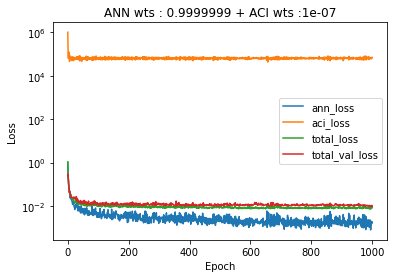

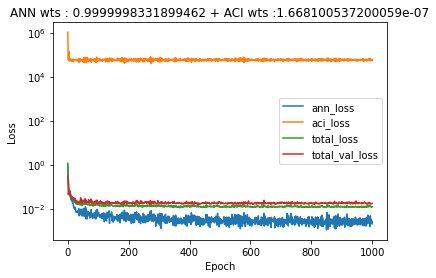

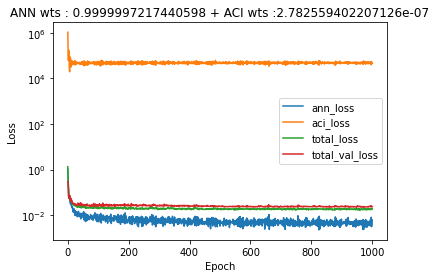

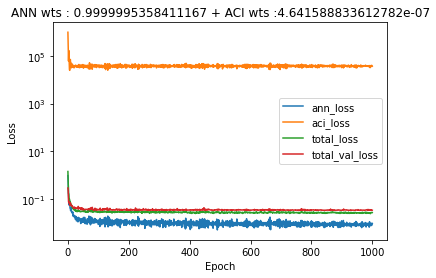

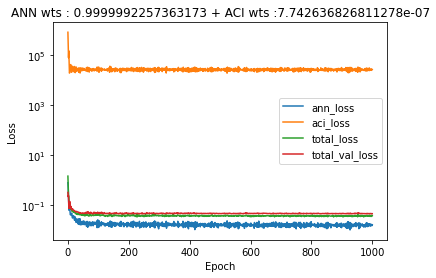

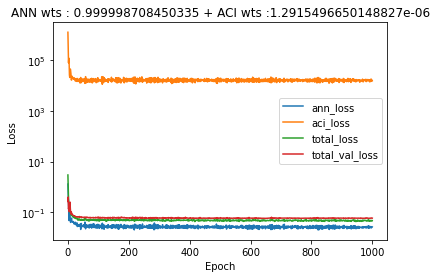

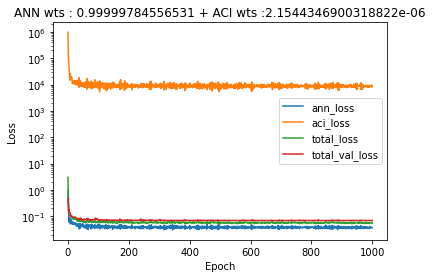

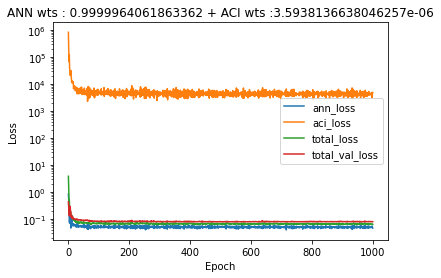

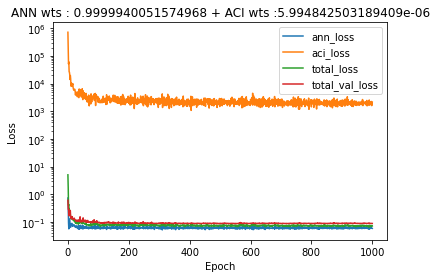

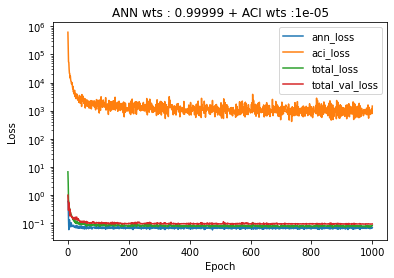

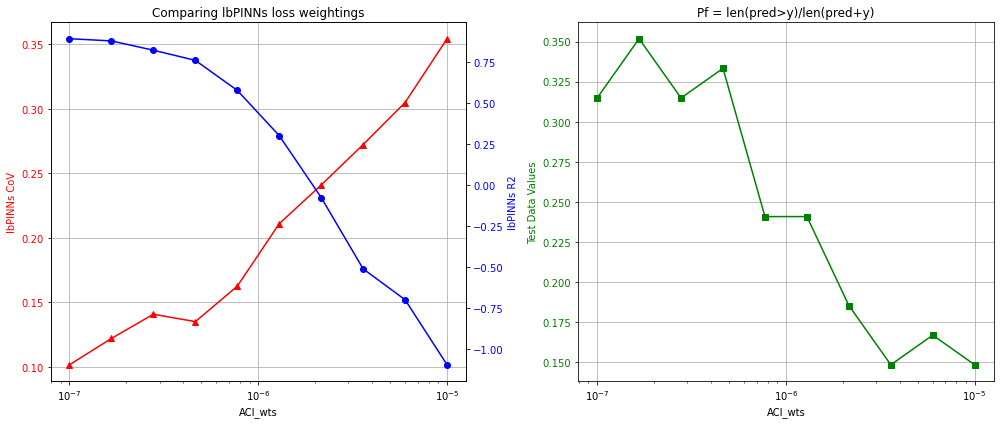

        ACI_wts   ANN_wts   CoV  R2_score    Pf
0  1.000000e-07  1.000000  0.10      0.89  0.31
1  1.668101e-07  1.000000  0.12      0.88  0.35
2  2.782559e-07  1.000000  0.14      0.82  0.31
3  4.641589e-07  1.000000  0.14      0.76  0.33
4  7.742637e-07  0.999999  0.16      0.58  0.24
5  1.291550e-06  0.999999  0.21      0.30  0.24
6  2.154435e-06  0.999998  0.24     -0.08  0.19
7  3.593814e-06  0.999996  0.27     -0.51  0.15
8  5.994843e-06  0.999994  0.30     -0.70  0.17
9  1.000000e-05  0.999990  0.35     -1.10  0.15


In [3]:
#PINN 모델 학습 후 저장, PINN 가중치별 성능 비교 값 출력
from Train_Test_dataset import train_dataset, val_dataset,  x_scaler, y_scaler,test_x_sc_tn, test_y_sc_tn
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import  DataLoader
import ANNs_class as ANN
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

exponents = np.linspace(-7, -5, 10)  
fine_tuned_values = 10 ** exponents  
list_aci = []

# loss_pw 설정
for loss_w in fine_tuned_values:
    loss_pw = 1 - loss_w
    
class lbPINN_graph:
    def __init__(self,loss_pw_list, loss_w_list, train_loss_list, val_loss_list, best_val_loss_list, cov_list, r2_list,Pf_list, model_list, train_costs_list, train_costs_p_list):
        self.loss_pw_list = loss_pw_list
        self.loss_w_list = loss_w_list
        self.train_loss_list = train_loss_list
        self.val_loss_list = val_loss_list
        self.best_val_loss_list = best_val_loss_list
        self.cov_list = cov_list
        self.r2_list = r2_list
        self.Pf_list = Pf_list
        self.model_list = model_list
        self.train_costs_list = train_costs_list
        self.train_costs_p_list = train_costs_p_list
        
    def train_loss(self):
        for i in range(len(self.model_list)):
            plt.title(f'ANN wts : {self.loss_w_list[i]} + ACI wts :{self.loss_pw_list[i]}')
            plt.semilogy(self.train_costs_list[i], label = 'ann_loss')
            plt.semilogy(self.train_costs_p_list[i], label = 'aci_loss')
            plt.semilogy(self.train_loss_list[i], label = 'total_loss')
            plt.semilogy(self.val_loss_list[i], label = 'total_val_loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()
    
    def lbPINNs_result(self):
        fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(14, 6))
        
        x_under = self.loss_pw_list
        x_on = self.loss_w_list
        y_left = self.cov_list
        y_right = self.r2_list
        Pf_graph = self.Pf_list

        ax1.semilogx(x_under, y_left, 'r-', marker='^', label='Cov')
        ax1.set_xlabel('ACI_wts')
        ax1.set_ylabel('lbPINNs CoV', color='r')
        ax1.tick_params(axis='y', labelcolor='r')

        ax2 = ax1.twinx()
        ax2.semilogx(x_under, y_right, 'b-', marker='o', label='R2 score')
        ax2.set_ylabel('lbPINNs R2', color='b')
        ax2.tick_params(axis='y', labelcolor='b')

        ax1.grid(True)
        ax1.set_title('Comparing lbPINNs loss weightings')

        ax3.semilogx(x_under, Pf_graph, 'g-', marker='s', label='Test Data')
        ax3.set_xlabel('ACI_wts')
        ax3.set_ylabel('Test Data Values', color='g')
        ax3.tick_params(axis='y', labelcolor='g')

        # Add grid and title to the right plot
        ax3.grid(True)
        ax3.set_title('Pf = len(pred>y)/len(pred+y)')

        # Adjust the layout
        plt.tight_layout()

        # Show the plot
        plt.show()  

def for_ACI(x_data, x_scaler): #x_data = sc_tn
    x_data_unsc_tn = x_scaler.inverse_transform(x_data)
    fcm = x_data_unsc_tn[:,2]
    Ld = x_data_unsc_tn[:,1]
    db = x_data_unsc_tn[:,3]
    aci_y_unsc = (Ld*torch.sqrt(fcm))/(0.19*db)
    #aci_y_sc  = y_scaler.transform(aci_y_unsc)
    return aci_y_unsc # output type : unscaled tensor

def for_pinn_training(device, model, criterion, optimizer, nb_epochs, train_dataloader, validation_dataloader, x_scaler, y_scaler, loss_p_num):
    loss_num = 1-loss_p_num
    torch.manual_seed(12)
    model = model.to(device)
    train_losses = []
    val_losses = []
    ann_losses =[]
    aci_losses =[]

    best_val_loss = float('inf')
    best_model_wts = None
    best_epoch = -1
    
    for epoch in range(nb_epochs + 1):
        model.train()  # 모델을 훈련 모드로 설정
        train_loss1 = 0
        ann_loss1 = 0
        aci_loss1 = 0

        for data in train_dataloader:
            optimizer.zero_grad()
            
            x, y = data 
            x = x.to(device) # sc_tn, torch.Size([27(batch size), 14])
            y_train = y.to(device) #sc_tn x: torch.Size([27]) => loss 구할때 view(-1,1)하기 
            p_train = model(x) 
            ann_loss = criterion(p_train, y_train)
            #print('ann_loss:',ann_loss)
            aci_unsc_y = for_ACI(x, x_scaler).view(-1,1)
            p_train_unsc = y_scaler.inverse_transform(p_train)
            aci_loss = criterion(p_train_unsc ,aci_unsc_y)
            #print('aci_loss:', aci_loss)
            total_loss = loss_num*ann_loss + loss_p_num*aci_loss 
            #print(f'total_loss({total_loss}) = {loss_num}*ann_loss({ann_loss}) + {loss_p_num}*aci_loss({aci_loss})')

            total_loss.backward(retain_graph=True)
            optimizer.step()
            #print('next_total loss:', total_loss)
            train_loss1 += total_loss.item()
            #print('last total loss:', train_loss1)
            ann_loss1 += ann_loss.item()
            #print('ann_loss:', ann_loss1)
            aci_loss1 += aci_loss.item()
            #print('aci_loss:', aci_loss1)
        
        # 모델 검증
        model.eval()  # 모델을 평가 모드로 설정
        val_loss = 0
        with torch.no_grad():
            for val_data in validation_dataloader:
                x_val, y_val = val_data
                x_val = x_val.to(device)
                p_val = model(x_val)
                aci_y_val = for_ACI(x_val, x_scaler).view(-1,1) #unsc_tn
                
                p_val_unsc = y_scaler.inverse_transform(p_val)
                
                val_cost_p = criterion(aci_y_val, p_val_unsc)
                val_cost = criterion(p_val , y_val)
                
                total_val_loss = ((loss_num)*val_cost + (loss_p_num)*val_cost_p)
                val_loss += total_val_loss.item()
        
        # calculate mean for each batch
        avg_train_loss = train_loss1 / len(train_dataloader)
        avg_val_loss = val_loss / len(validation_dataloader)
        avg_ann_loss = ann_loss1/ len(train_dataloader)
        avg_aci_loss = aci_loss1/len(train_dataloader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        ann_losses.append(avg_ann_loss)
        aci_losses.append(avg_aci_loss)
        
    
        if epoch % 100== 0:
            print(f"Epoch: {epoch:4d}/{nb_epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")
        
         # Check for best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = model.state_dict().copy()
            best_epoch = epoch
            epochs_since_improvement = 0
            print(f"New best model found at epoch {epoch} with val loss {avg_val_loss:.6f}")
        else:
            epochs_since_improvement += 1
        
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, best_val_loss, ann_losses, aci_losses

def for_pinn_testing(model_pinn, test_x_sc_tn, test_y_sc_tn, device, y_scaler, title):
    #model_pinn.eval() 상관없음 
    test_y_unsc_tn = y_scaler.inverse_transform(test_y_sc_tn)
    test_y_unsc_np = test_y_unsc_tn.detach().cpu().numpy()
    test_x_sc_tn = test_x_sc_tn.to(device)
    
    #pinn
    pred_sc_tn = model_pinn(test_x_sc_tn) #torch.Size([54, 1])
    indices = (pred_sc_tn > test_y_sc_tn).nonzero(as_tuple=True)[0].tolist() #
    Pf = len(indices)/ len(test_y_sc_tn)#
    pred_unsc_tn = y_scaler.inverse_transform(pred_sc_tn) #torch.Size([54, 1])
    test_y_unsc_tn = y_scaler.inverse_transform(test_y_sc_tn) #torch.Size([54])

    div = test_y_unsc_tn/pred_unsc_tn #torch.Size([54, 1])
    cov = torch.std(div)/torch.mean(div) #torch.Size([])
    cov = cov.item()
    predict_np = pred_unsc_tn.detach().cpu().numpy()
    ss_res = np.sum((test_y_unsc_np - predict_np)**2)
    ss_tot = np.sum((test_y_unsc_np - np.mean(test_y_unsc_np))**2)
    r2 = 1 - (ss_res / ss_tot)
    #r2 = r2_score(test_y_unsc_np, predict_np)

    return cov, r2, Pf
def make_various_final_PINN(device, nb_epochs, train_dataloader, validation_dataloader, x_scaler, y_scaler, test_x_sc_tn, test_y_sc_tn):
    train_loss_list=[]
    val_loss_list=[]
    best_val_loss_list =[]
    cov_list=[]
    r2_list =[]
    Pf_list =[]
    model_list =[]
    loss_pw_list = []
    loss_w_list = []
    train_costs_list =[]
    train_costs_p_list =[]
    #t = -11
    exponents = np.linspace(-7, -5, 10)  
    fine_tuned_values_aci = 10 ** exponents
    t = fine_tuned_values_aci   
    #t = [3e-07]
    #t = [-11,3e-07,1e-09,5e-08, 1e-06,1e-05]
    #t = [0, 1e-09, 2e-09, 1e-08, 5e-08, 1e-07, 5e-07, 1e-06, 5e-06, 1e-05]
    #t = np.arange(0,1e-6, 2e-8)
    #for i in range(t, 1):
    #for i in t:
    #    if i == -11: #0: #t
    #        loss_pw = 0
    #    else :
    #        loss_pw = 10**i #10**i
    #    loss_w = 1 - loss_pw
          
    #exponents = np.arange(-10, 1, 1, dtype=float)
    #fine_tuned_values = np.sort(np.concatenate([10**exponents, 5 * 10**(exponents - 1)]))

    for loss_pw in fine_tuned_values:
        loss_w = 1 - loss_pw
        
        model = ANN.ANN_batch_4(14,83,39,49,83,1).to(device).double()
        criterion = nn.MSELoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.03444508252211158, weight_decay= 0)
        
        def reset_weights(m):
            if isinstance(m, torch.nn.Linear):
                m.reset_parameters()
        
        model.apply(reset_weights)
        

        trained_model, train_losses, val_losses, best_val_loss, train_costs, train_costs_p = for_pinn_training(device, model, criterion, optimizer, nb_epochs, train_dataloader, validation_dataloader, x_scaler, y_scaler, loss_pw)
        trained_model_cov, trained_model_r2, trained_model_Pf = for_pinn_testing(trained_model, test_x_sc_tn, test_y_sc_tn, device, y_scaler, title=None)
        
        train_loss_list.append(train_losses)
        val_loss_list.append(val_losses)
        best_val_loss_list.append(best_val_loss)
        cov_list.append(trained_model_cov)
        r2_list.append(trained_model_r2)
        Pf_list.append(trained_model_Pf)
        model_list.append(trained_model)
        loss_pw_list.append(loss_pw)
        loss_w_list.append(loss_w)
        train_costs_list.append(train_costs)
        train_costs_p_list.append(train_costs_p)
        

    return loss_pw_list, loss_w_list, train_loss_list, val_loss_list, best_val_loss_list, cov_list, r2_list,Pf_list, model_list, train_costs_list, train_costs_p_list



#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
generator=torch.Generator().manual_seed(44) #42
#criterion4 = nn.MSELoss().to(device) 
model_final_pinn = ANN.ANN_batch_4(14,83,39,49,83,1).to(device).double()
optimizer4 = torch.optim.Adam(model_final_pinn.parameters(), lr =  0.03444508252211158) #
ann4_train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True, generator=generator) # 데이터 고정
ann4_validation_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, generator=generator) #데이터 고정n4_validation_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, generator=generator) #데이터 고정


a1,b1,c1,d1,e1,f1, g1, p1, h1, i1 ,j1  =make_various_final_PINN(device, 1000, ann4_train_dataloader, ann4_validation_dataloader, x_scaler, y_scaler,test_x_sc_tn, test_y_sc_tn)
results = lbPINN_graph(a1,b1,c1,d1,e1,f1, g1,p1, h1, i1 ,j1)
results.train_loss()
results.lbPINNs_result()

aci_wts_list = a1 
ann_wts_list = b1
model_list = h1 # 여러 PINN 모델들 

def make_model_pairs(models, titles):
    return list(zip(models, titles))

pairs = make_model_pairs(model_list[:], aci_wts_list[:])

final_pinn_df = pd.DataFrame({
    'ACI_wts':a1,
    'ANN_wts':b1,
    'CoV': f1,
    'R2_score':g1,
    'Pf':p1
})
final_pinn_df['ANN_wts'] = 1-final_pinn_df['ACI_wts']
final_pinn_df[['CoV','R2_score','Pf']] = final_pinn_df[['CoV','R2_score','Pf']].round(2)

print(final_pinn_df)

#적당한 PINN 모델 저장  
#torch.save(model_list[4].state_dict(), 'trained_model/Pinn4_58_24_new.pt')